In [ ]:
!srun python learn_error.py configs/config.yaml

wandb: Currently logged in as: thomashelfer (multimodal-supernovae). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /data/tedwar42/thelfer1/TorchGRTL/wandb/run-20240711_153027-ny4w4meh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wise-butterfly-2
wandb: ⭐️ View project at https://wandb.ai/multimodal-supernovae/TorchGRTL
wandb: 🚀 View run at https://wandb.ai/multimodal-supernovae/TorchGRTL/runs/ny4w4meh
Folder 'Run15157599' already exists.
Copied script to 'Run15157599'.
Executing the model on : cuda:0
lambda_fac <class 'float'>
Loading data
100%|██████████| 7/7 [00:01<00:00,  5.64it/s]
mean tensor(0.0002, dtype=torch.float64, grad_fn=<MeanBackward0>)
Input Shape: torch.Size([336, 16, 16, 16, 25])
Output Shape: torch.Size([1, 25, 22, 22, 22])
diff -3
dx 0.125
training


In [2]:
!pip install .
!pip install pandas scikit-learn tensorboard torch tqdm
!pip install pyinterpx
!pip install scikit-learn

Processing /Users/tom/Desktop/TorchGRTL
  Preparing metadata (setup.py) ... done
  Created wheel for GeneralRelativity: filename=GeneralRelativity-0.1-py3-none-any.whl size=3399 sha256=dae5bc717b1053142db7e5015270780cc10a9244ce3543f02b9c4fe68f18e953
  Stored in directory: /private/var/folders/br/rfmwms_96jb8rrxcrsp81mqh0000gn/T/pip-ephem-wheel-cache-ho8fhkbd/wheels/7e/56/3a/dbd713ac6a7a2c158d2d7cbf655d63eb4a1db21d5035d47ca4
Successfully built GeneralRelativity

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached tensorboard-2.14.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached scipy-1.10.1-cp38-cp38-macosx_10_9_x86_64.whl.metadata (53 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)

In [80]:
import torch
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import r2_score
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader, TensorDataset, random_split

%reload_ext tensorboard
from GeneralRelativity.Utils import (
    get_box_format,
    TensorDict,
    cut_ghosts,
    keys,
    keys_all,
)
from GeneralRelativity.DimensionDefinitions import FOR1, FOR2, FOR3, FOR4
from GeneralRelativity.FourthOrderDerivatives import diff1, diff2
from pyinterpx.Interpolation import *
from GeneralRelativity.TensorAlgebra import (
    compute_christoffel,
    compute_trace,
    compute_christoffel_fast,
    raise_all,
)
from GeneralRelativity.CCZ4Geometry import compute_ricci
from GeneralRelativity.Constraints import constraint_equations


from SuperResolution.models import (
    SuperResolution3DNet,
    calculate_test_loss,
    load_model,
    check_performance,
)
from SuperResolution.losses import Hamiltonian_loss

time_stamp = int(time.time())

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Executing the model on :", device)

torch.manual_seed(1)
np.random.seed(4)
writer = SummaryWriter()

Executing the model on : cpu


In [128]:
small_data = False

# Loading small testdata
if small_data:
    filenamesX = (
        "/home/thelfer1/scr4_tedwar42/thelfer1/data_gen_binary/outputXdata_level1_*"
    )
    num_vars = 100
    factor = 2  # how much refinement
    scaling_factor = 1e-2  # Scaling factor for error
    dataX = get_box_format(filenamesX, num_vars)
    # Cutting out extra values added for validation
    dataX = dataX[:, :, :, :, :25]
else:
    # Instantiate the model
    factor = 4  # how much refinement
    res_level = 6
    scaling_factor = 0.001
    downsample = 1
    filenamesX = f"outputXdata_level6_step001*.dat"  # "/home/thelfer1/scr4_tedwar42/thelfer1/high_end_data/outputXdata_level{res_level}_step*.dat"

    num_vars = 25
    dataX = get_box_format(filenamesX, num_vars)
    # Cutting out extra values added for validation
    dataX = dataX[:, :, :, :, :25]

dataX_shape = dataX.shape
# Permute data to put the channel as the second dimension (N, C, H, W, D)
dataX = dataX.permute(0, 4, 1, 2, 3)

Loading data


  0%|          | 0/2 [00:00<?, ?it/s]

In [129]:
dataX.shape

torch.Size([160, 25, 16, 16, 16])

In [130]:
# global step counter
counter = 0

losses_train = []
losses_val = []
losses_val_interp = []
steps_val = []

In [131]:
# Create a random 3D low-resolution input tensor (batch size, channels, depth, height, width)
input_tensor = torch.randn(
    1,
    dataX.shape[1],
    dataX.shape[2] // downsample,
    dataX.shape[3] // downsample,
    dataX.shape[4] // downsample,
).to(
    torch.double
)  # Adjust dimensions as needed

# Instantiate the model
net = SuperResolution3DNet(factor, scaling_factor).to(torch.double)

print(input_tensor.shape)
# Forward pass to obtain the high-resolution output
output_tensor, _ = net(input_tensor)
# Relevant for ghosts
diff = (dataX_shape[-2] - output_tensor.shape[-1]) // 2
print(diff)
# Check the shape of the output
print("Input Shape:", input_tensor.shape)
print("Output Shape:", output_tensor.shape)

torch.Size([1, 25, 16, 16, 16])
-14
Input Shape: torch.Size([1, 25, 16, 16, 16])
Output Shape: torch.Size([1, 25, 44, 44, 44])


In [132]:
optimizerBFGS = torch.optim.LBFGS(
    net.parameters(), lr=0.1
)  # Use LBFGS sometimes, it really does do magic sometimes, though its a bit expensive
optimizerADAM = torch.optim.Adam(net.parameters(), lr=0.0001)

In [141]:
# Define the ratio for the split (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 1 - train_ratio
batch_size = 1

# Calculate the number of samples for each split
num_samples = len(dataX)
num_train = int(train_ratio * num_samples)
num_test = num_samples - num_train


# Create a dataset from tensors
dataset = TensorDataset(dataX)

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

# Create DataLoader for batching -- in case data gets larger
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)  # Batch size for test can be larger if you have the memory

In [142]:
# Magical loss coming from General Relativity
if small_data:
    oneoverdx = (2 * 32.0) / 16.0
else:
    oneoverdx = (64.0 * 2**res_level) / 512.0 * float(factor) / float(downsample)

print(f"dx = {1./oneoverdx}")
my_loss = Hamiltonian_loss(oneoverdx)

dx = 0.03125


In [143]:
!ls models

x1_lvl5            x1_lvl8            x2_lvl5            x4_lvl5
x1_lvl6            x1_lvl9            x2_lvl6
x1_lvl7            x2_d2_lvl5         x2_lvl7
x1_lvl7_align_true x2_d2_lvl5_L1      x2_lvl8


In [144]:
restart = True
load_restart_data = False
if restart:
    net, config = load_model("models/x4_lvl5")
if restart and load_restart_data:
    num_vars = 25
    dataX = get_box_format(config["filenamesX"], num_vars)
    oneoverdx = (64.0 * 2**res_level) / 512.0 * float(factor) / float(downsample)

Config file path: models/x4_lvl5/factor_4.yaml
model_epoch_counter_0000000068_data_time_1722712289.pth
cpu
loaded model from models/x4_lvl5/model_epoch_counter_0000000068_data_time_1722712289.pth


In [121]:
# Check performance
L2Hmodelerror, L2Hinterp = check_performance(
    net=net,
    my_loss=my_loss,
    datafolder=f"/home/thelfer1/scr4_tedwar42/thelfer1/high_end_data_3/outputXdata_level{res_level}_step*.dat",
    device=device,
)
print(f"we have the performance {L2Hmodelerror} with baseline {L2Hinterp}")

TypeError: check_performance() got an unexpected keyword argument 'my_loss'

In [61]:
# For validation error
L1Loss = torch.nn.L1Loss()
ham_loss = Hamiltonian_and_momentum_loss(oneoverdx)

print("training")
pbar = trange(n_steps)
for i in pbar:
    total_loss_train = 0
    for (y_batch,) in train_loader:
        net.train()
        batchcounter = 0
        # for X_batch, y_batch in train_loader:
        y_batch = y_batch.to(device)
        X_batch = y_batch[:, :, ::downsample, ::downsample, ::downsample].clone()
        if diff != 0:
            y_batch = y_batch[
                :,
                :25,
                diff - 1 : -diff - 1,
                diff - 1 : -diff - 1,
                diff - 1 : -diff - 1,
            ]
        batchcounter += 1

        # This is needed for LBFGS
        def closure():
            if torch.is_grad_enabled():
                optimizerBFGS.zero_grad()
            y_pred, y_interp = net(X_batch)

            loss_train = my_loss(y_pred, y_batch)
            if loss_train.requires_grad:
                loss_train.backward()
            return loss_train

        # doing some ADAM first to warm up, sometimes BFGS fuckes up if you start too early
        if counter < ADAMsteps:
            y_pred, y_interp = net(X_batch)

            loss_train = my_loss(y_pred, y_batch)
            optimizerADAM.zero_grad()
            loss_train.backward()
            optimizerADAM.step()
            # print(f'ADAM {batchcounter}')

        else:
            optimizerBFGS.step(closure)
            # print(f'BFGS {batchcounter}')

        loss_train = closure()
        total_loss_train += loss_train.item()

    # Calculate the average training loss
    average_loss_train = total_loss_train / len(train_loader)
    # Log the average training loss
    writer.add_scalar("loss/train", average_loss_train, counter)
    losses_train.append(average_loss_train)
    if np.isnan(average_loss_train):
        print("we got nans")

    # Validation

    if counter % 1 == 0:
        with torch.no_grad():
            net.eval()
            total_loss_val = 0.0
            interp_val = 0.0
            L1Loss_val = 0.0
            L1Loss_val_interp = 0.0
            loss_hard_base = 0.0
            Ham_loss = 0.0
            Ham_loss_interp = 0.0
            for (y_val_batch,) in test_loader:
                # for X_val_batch, y_val_batch in test_loader:
                # Transfer batch to GPU
                y_val_batch = y_val_batch.to(device)
                X_val_batch = y_val_batch[
                    :, :, ::downsample, ::downsample, ::downsample
                ].clone()
                if diff != 0:
                    y_val_batch = y_val_batch[
                        :,
                        :25,
                        diff - 1 : -diff - 1,
                        diff - 1 : -diff - 1,
                        diff - 1 : -diff - 1,
                    ]
                y_val_pred, y_val_interp = net(X_val_batch)
                loss_val = my_loss(y_val_pred, y_val_batch)
                total_loss_val += loss_val.item()
                interp_val += my_loss(y_val_interp, y_val_batch).item()
                if downsample == factor:
                    print(y_val_pred[:, 0, :, :, :].shape)
                    print(y_val_batch[:, 0, :, :, :].shape)
                    L1Loss_val += L1Loss(
                        y_val_pred[:, 0, :, :, :], y_val_batch[:, 0, :, :, :]
                    )
                    L1Loss_val_interp += L1Loss(
                        y_val_interp[:, 0, :, :, :], y_val_batch[:, 0, :, :, :]
                    )
                    loss_hard_base += ham_loss(y_val_batch, None)

                    if config["loss"] == "L1":
                        Ham_loss_interp += ham_loss(y_val_interp, None)
                        Ham_loss += ham_loss(y_val_pred, None)
            # Calculate the average loss
            average_loss_val = total_loss_val / len(test_loader)
            average_interp_val = interp_val / len(test_loader)
            losses_val_interp.append(average_interp_val)
            losses_val.append(average_loss_val)
            steps_val.append(counter)
            writer.add_scalar("loss/test", loss_val.item(), counter)

    if counter % write_out_freq == 0:
        # Writing out network and scaler
        torch.save(
            net.state_dict(),
            f"{folder_name}/model_epoch_counter_{counter:010d}_data_time_{time_stamp}.pth",
        )
    # Advancing global counter
    counter += 1

training


  0%|          | 0/1 [00:00<?, ?it/s]

7.973876499427724e-05


In [161]:
plt.figure(figsize=(9, 6))
print(f"final val loss {losses_val[-1]} relative {losses_val_interp[-1]}")
plt.plot(np.array(losses_train), label="Train")
plt.plot(steps_val, np.array(losses_val), label="Val", linewidth=0.5)
plt.plot(steps_val, np.array(losses_val_interp), label="baseline", linewidth=0.5)
plt.yscale("log")
plt.legend()

IndexError: list index out of range

<Figure size 900x600 with 0 Axes>

In [162]:
net.to(device)
net.eval();

In [166]:
def get_constraints(output, oneoverdx):
    output = output.permute(0, 2, 3, 4, 1)

    # cutting ghosts off, otherwise you will run into problems later
    dataXcut = cut_ghosts(output)

    # creating dict with values
    vars = TensorDict(dataXcut, keys)
    # creating dict with derivatives
    d1 = TensorDict(diff1(output, oneoverdx), keys)
    d2 = TensorDict(diff2(output, oneoverdx**2), keys)
    # calculating variables required for constraints
    h_UU = torch.inverse(vars["h"])
    chris = compute_christoffel(d1["h"], h_UU)
    # Computing Constraints
    out = constraint_equations(vars, d1, d2, h_UU, chris)
    return out

In [167]:
# Get comparison with classical methods
(y_batch,) = next(iter(test_loader))
y_batch = y_batch.to(device)
X_batch = y_batch[:, :, ::downsample, ::downsample, ::downsample].clone()
y_batch = y_batch[
    :,
    :25,
    diff - 1 : -diff - 1,
    diff - 1 : -diff - 1,
    diff - 1 : -diff - 1,
]

# Interpolation compared to what is used typically in codes ( we interpolate between 6 values with polynomials x^i y^k z^k containing powers up to 3)
shape = X_batch.shape

net.eval()
y_pred, y_interpolated = net(X_batch.detach())
ham = get_constraints(y_pred, oneoverdx)
ham_ref = get_constraints(y_interpolated, oneoverdx)


# y_interpolated = interpolation(X_batch.detach().cpu()).detach().to(torch.double)
# Create subplots

([], [])

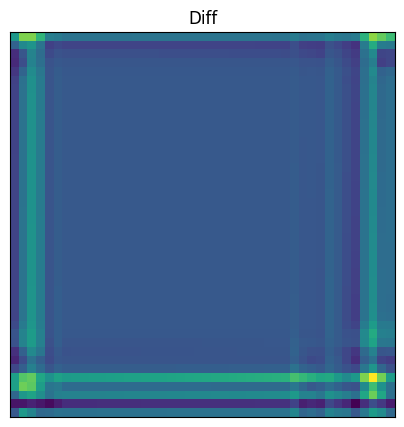

In [180]:
box = 0
channel = 0
slice = 3
fig = plt.figure(figsize=(15, 5))

# Plot ground truth
plt.subplot(1, 2, 1)
plt.title("Diff")
im0 = plt.imshow(
    y_pred[box, channel, :, :, slice].cpu().detach().numpy()
    - y_interpolated[box, channel, :, :, slice].cpu().detach().numpy(),
    # vmin=-1e-7,
    # vmax=1e-7,
    cmap="viridis",
)
plt.xticks([])
plt.yticks([])

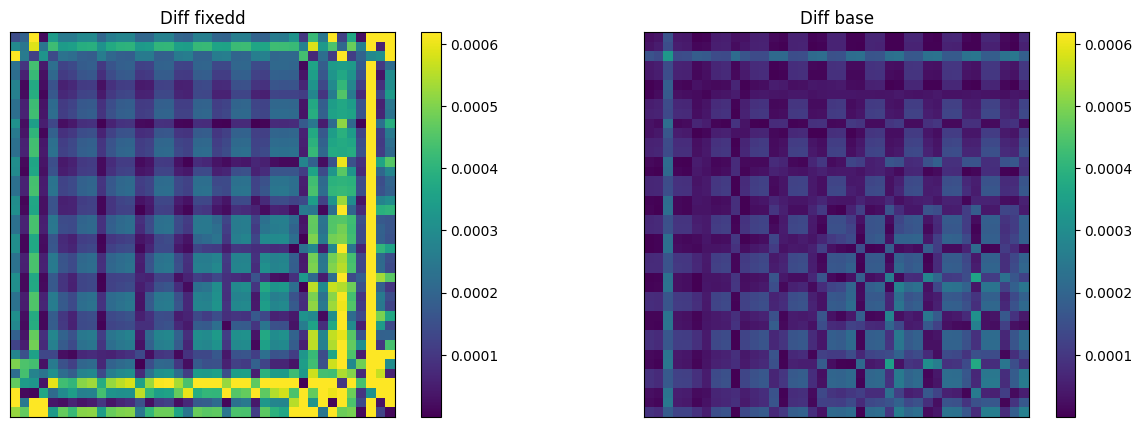

In [191]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Diff fixedd")
vmin = np.min(np.abs(ham_ref["Ham"][box, :, :, :].cpu().detach().numpy()))
vmax = np.max(np.abs(ham_ref["Ham"][box, :, :, :].cpu().detach().numpy()))
im0 = plt.imshow(
    np.abs(ham["Ham"][box, :, :, slice].cpu().detach().numpy()),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Diff base")
im0 = plt.imshow(
    np.abs(ham_ref["Ham"][box, :, :, slice].cpu().detach().numpy()),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [192]:
if factor == downsample:
    box = 0
    channel = 0
    slice = 2
    fig = plt.figure(figsize=(15, 5))

    # Plot ground truth
    plt.title("Diff")
    im0 = plt.imshow(
        y_batch[box, channel, :, :, slice].cpu().detach().numpy()
        - y_interpolated[box, channel, :, :, slice].cpu().detach().numpy(),
        # vmin=-1e-7,
        # vmax=1e-7,
        cmap="viridis",
    )
    plt.xticks([])
    plt.yticks([])

    plt.colorbar()

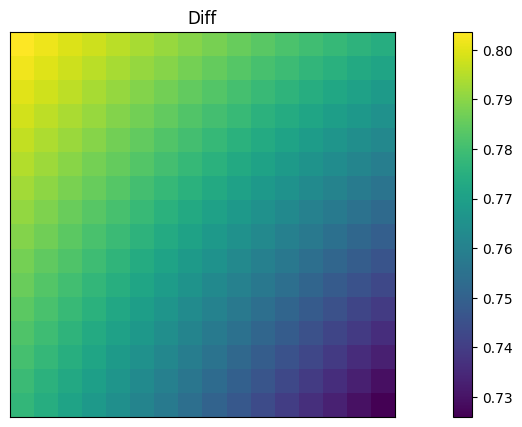

In [193]:
fig = plt.figure(figsize=(15, 5))

# Plot ground truth
plt.title("Diff")
im0 = plt.imshow(
    X_batch[box, channel, :, :, slice].cpu().detach().numpy(),
    # vmin=min_val,
    # vmax=max_val,
    cmap="viridis",
)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [160]:
box = 0
channel = 0
slice = 5

# net.eval()
# y_pred, y_interpolated = net(X_batch.detach())

if downsample == factor:
    plt.plot(
        y_batch[box, channel, :, slice, slice].detach().cpu().numpy(),
        label="ground truth",
    )
plt.plot(
    y_pred[box, channel, :, slice, slice].detach().cpu().numpy(),
    label="neural network ",
)
plt.plot(
    y_interpolated[box, channel, :, slice, slice].detach().cpu().numpy(),
    label="interpolation ",
    linestyle=":",
    alpha=0.6,
    linewidth=2,
)
# plt.yscale("log")
plt.legend()

TypeError: tuple indices must be integers or slices, not tuple

In [157]:
box = 0
channel = 0
slice = 5

# net.eval()
# y_pred = net(X_batch.detach())


plt.plot(
    (
        y_pred[box, channel, :, slice, slice].detach().cpu().numpy()
        - y_interpolated[box, channel, :, slice, slice].detach().cpu().numpy()
    ),
    label="interpolation residual",
    linestyle=":",
    alpha=0.6,
)
# plt.yscale("log")
plt.legend()

TypeError: tuple indices must be integers or slices, not tuple

In [152]:
# Calculate L2Ham performance
my_loss = Hamiltonian_loss(oneoverdx)

net.eval()
y_pred, _ = net(X_batch.detach())

print(
    f"Reference data L2 Ham {my_loss(y_batch[:, :, :, :, :], torch.tensor([])).detach().cpu().numpy()}\n"
)
print(
    f"Neural Network L2 Ham {my_loss(y_pred[:, :, :, :, :], torch.tensor([])).detach().cpu().numpy()}\n"
)
print(
    f"Interpolation L2 Ham  {my_loss(y_interpolated, torch.tensor([])).detach().numpy()}\n"
)
print("--------------------\n")

Reference data L2 Ham 1.561885776001435e-06



TypeError: tuple indices must be integers or slices, not tuple

In [82]:
# Writing out network and scaler
torch.save(net.state_dict(), file_path)

# Write out model for the C++ code to pick up
# traced_script_module = torch.jit.trace(net, X)
# traced_script_module.save("model.pt")